## MVA, Reinforcement Learning TP1
## Dynamic Programming and Reinforcement Learning
Lecturer: Matteo Pirotta v0.1 (October 29, 2018)

Students: Pierre-Louis Guhur and Thibault Desfontaines


## 1. Dynamic Programming


![title](img/mdp.png)


**Q1: Implement the discrete MDP model. In this simple MDP it is simple to guess the optimal policy $π_∗$. What is it?**

The optimal policy maximizes a fraction $\gamma^t$ of the reward in expectation. Therefore, we want to reach $s_2$ and remaining there doing in loop the action $a_2$. The shortest stochastic path to $s_2$ is to do $a_1$ in $s_0$ and $s_1$. This means that the optimal policy is π0 = [a1, a1, a2].

In [3]:
import numpy as np 

transitions = np.array([[[0.55, 0.3, 1],
                         [0.45, 0.7, 0],
                         [0, 0, 0]],
                        [[1, 0, 0],
                         [0, 0.4, 1],
                         [0, 0.6, 0]],
                        [[0, 0, 0],
                         [1, 0.6, 0],
                         [0, 0.4, 1]]
                       ], dtype=float)
gamma = 0.95
rewards = np.array([[0, 0, 0.05],
                    [0, 0, 0],
                    [0, 1, 0.9]], dtype=float)


**Q2: Implement and run value iteration (VI) in order to identify a 0.01–optimal policy. Recall that the stopping criterion (theory slides) is to stop when
$$∥v^{k+1} − v^k∥_∞ < ε$$
which implies that [Puterman, 1994, Th. 6.3.1]
$$∥v^{π^+_{k+1}} −v_∗∥< \frac{2εγ}{1−γ}$$
Plot $∥v_k −v_∗∥_∞$ as a function of iteration k. Implement policy evaluation to compute $v_∗$, i.e. the value
function of the optimal policy.**


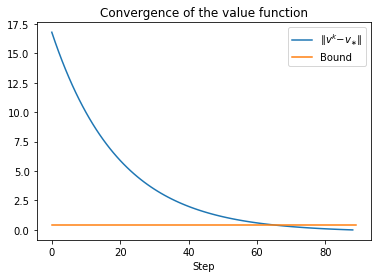

In [18]:
import matplotlib.pyplot as plt

def value_iteration(transitions, rewards, eps=1e-2, max_iter=1000, gamma=0.95):
    n_states, n_actions = rewards.shape
    old_value = np.zeros(n_states)
    value = np.zeros(n_states)
    values = []
    error = eps + 1
    n = 0

    while error >= eps and n < max_iter:
        for s in range(n_states):
            all_values = np.zeros(n_actions)
            for a in range(n_actions):
                all_values[a] = rewards[s, a] + gamma * transitions[s, :, a].dot(value)
            value[s] = np.max(all_values)
        error = np.max(value - old_value)
        values.append(value.copy())
        old_value = value.copy()
        n += 1

    return values

eps = 1e-2
gamma = 0.95
values = np.array(value_iteration(transitions, rewards, eps=eps, gamma=gamma))
v_opt = values[-1]
errors = np.max(np.abs(values - v_opt), axis=1)
bound = 2*eps*gamma/(1-gamma)
plt.plot(errors, label="$∥v^k −v_∗∥$")
plt.plot([0,len(errors)], [bound, bound], label="Bound")
plt.legend()
plt.xlabel("Step")
plt.title("Convergence of the value function")
plt.show()

**Q3: implement exact policy iteration (PI) with initial policy $π_0$ = [a1, a1, a2]. Compare the speed of convergence w.r.t. VI and discuss the relative merits of the two approaches.**

The initial policy given is the optimal policy. So we initialize our algorithm with $π0 = [a0, a1, a2]$

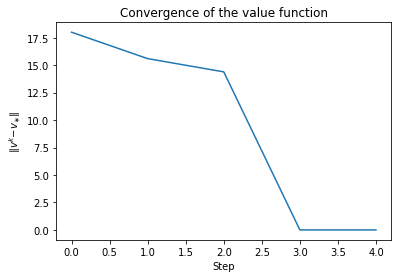

In [21]:
from numpy.linalg import inv

def _policy_evaluation(policy, t, r, gamma):
    n_states, n_actions = r.shape
    r_pi = np.array([r[x, int(policy[x])] for x in range(n_states)])
    p_pi = np.array([[t[x, y, int(policy[x])] for y in range(n_states)]  for x in range(n_states)])
    v_pi = inv(np.eye(n_states) - gamma*p_pi) @ r_pi
    return v_pi

def _policy_improvement(v_pi, t, r, gamma):
    n_states, n_actions = r.shape
    greedy = np.zeros(n_actions)
    policy = np.zeros(n_states)
    for x in range(n_states):
        for a in range(n_actions):
            greedy[a] = r[x, a] + gamma * t[x, :, a].dot(v_pi)
        policy[x] = np.argmax(greedy)
    return policy
    
def _has_converged(v, old_v):
    return np.max(np.abs(v - old_v))
   
def policy_iteration(transitions, rewards, eps=1e-2, max_iter=1000, gamma=0.95):
    n_states, n_actions = rewards.shape
    old_value = np.zeros(n_states)
    v_pi = np.ones(n_states)
    policy = np.zeros(n_states)
    values = []
    error = eps + 1
    n = 0
    
    while _has_converged(v_pi, old_value) and n < max_iter:
        old_value = v_pi.copy()
        v_pi = _policy_evaluation(policy, transitions, rewards, gamma)
        policy = _policy_improvement(v_pi, transitions, rewards, gamma)
        error = np.max(np.abs(v_pi - old_value))
        values.append(v_pi.copy())
        n += 1
        
    return values
     
    
eps = 1e-2
gamma = 0.95
values = np.array(policy_iteration(transitions, rewards, eps=eps, gamma=gamma))
v_opt = values[-1]
errors = np.max(np.abs(values - v_opt), axis=1)
plt.plot(errors, label="$∥v^k −v_∗∥$")
plt.ylabel("$∥v^k −v_∗∥$")
plt.xlabel("Step")
plt.title("Convergence of the value function")
plt.show()

The convergence of policy iteration is much faster than for value iteration, but each iteration is more computationnally expensive.
The convergence of policy iteration is also exact, while it is asymptotic for value iteration.

In [23]:
print("Time lapse for the policy iteration algorithm")
%timeit for x in range(100): policy_iteration(transitions, rewards, eps=eps, gamma=gamma)
print("Time lapse for the value iteration algorithm")
%timeit for x in range(100): value_iteration(transitions, rewards, eps=eps, gamma=gamma)

Time lapse for the policy iteration algorithm
61.8 ms ± 5.68 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Time lapse for the value iteration algorithm
411 ms ± 2.88 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 2. Reinforcement Learning



### 2.1. Policy evaluation. 

Consider the deterministic policy that is selecting the action right when available, otherwise up.

**Q4: denote with $V_n(x,a)$ the value function estimated using Monte-Carlo, i.e., empirical average:
$$V(s)= \frac{1}{N(s)}\sum_{k=1}^{N(s)}\sum_{t=1}^{T_{max}} \gamma^{t-1}r_t^{(k)}$$
with $s_1=s,a_t∼π(·|s_t)$
 where $\sum_s N(s) = n$ and $(r_t^{(k)})$
is the sequence of rewards obtained when simulating the k-th trajectory st
(using the simulator).
Build such estimator and plot $J_n − J^π$ as a function of n, where
$$V_π =[0.877,0.928,0.988,0,0.671,−0.994,0,−0.828,−0.877,−0.934,−0.994]T$$**

First, we need to evaluate the distribution of $\mu$ by sampling it many times.

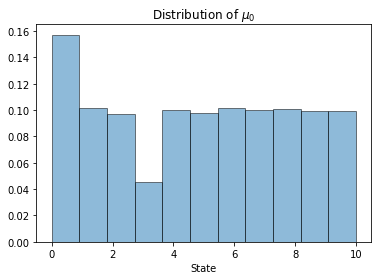

In [24]:
from gridworld import GridWorld1
env = GridWorld1

def evaluate_dist_mu(env, n_iter=50000):
    mu0 = [env.reset() for i in range(n_iter)]
    dist_mu, _ = np.histogram(mu0, bins=env.n_states)
    return mu0, dist_mu/n_iter

mu0, dist_mu = evaluate_dist_mu(env)
plt.figure()
plt.title("Distribution of $\mu_0$")
plt.xlabel("State")
plt.hist(mu0, bins=env.n_states, density=True, edgecolor='k', alpha=0.5)
plt.show()

Now, we can do the evaluation of the value function for a given deterministic policy

Text(0.5,1,'$J_n − J^π$ as a function of $n$')

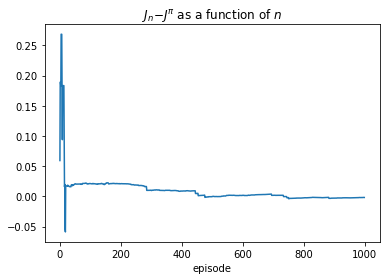

In [126]:
def _mc_simulations(env, policy, t_max=100, **kwargs):
    """ Do a Monte Carlo simulations with N episodes. """

    s = env.reset()
    t = 0
    term = False 
    rewards = []
    states = [s]
    actions = []
    while t < t_max and not term:
        a = policy(env.state_actions[s], s, **kwargs)
        s, r, term = env.step(s, a)
        rewards.append(r)
        actions.append(a)
        states.append(s)
        t += 1
    return rewards, states, actions

def _mc_evaluation(rewards, states, actions, n_states, gamma=0.95):
    """ 
    Evaluate the value function given the Monte-Carlo simulations.
    """
    value = np.zeros(n_states)
    for s in range(n_states):
        trajectories = _find_trajectories(s, states)
        Ns = len(trajectories)
        if Ns == 0:
            continue
        acc = 0.0
        for k in range(Ns):
            acc += _discounted_reward(rewards[trajectories[k]], gamma)
        value[s] = acc/Ns
    return value

def _find_trajectories(s, all_states):
    """
    Return a list of the indices of trajectories that start from s
    """
    trajectories = []
    for k, states in enumerate(all_states):
#         print(states)
        if states[0] == s:
            trajectories.append(k)
    return trajectories 

def _discounted_reward(rewards, gamma=0.95):
    """
    >>> _discounted_reward([0, 0, -1])
    -0.9025
    """
    acc = 0.0
    for t in range(1, len(rewards)+1):
        acc += gamma**(t-1)*rewards[t-1]
    return acc

def mc_value(env, policy, N=500, gamma=0.95, t_max=100, **kwargs):
    """ 
    Estimate a value function from Monte-Carlo simulations for a given policy.
    The simulation is run for N episodes. 
    Policy parameter is a callback function whose parameter is the set of actions
    """
    values = np.zeros((N, env.n_states))
    rewards, states, actions = [], [], []
    
    for n in range(N): # episodes
        episodes = _mc_simulations(env, policy, t_max=t_max, **kwargs)
        rewards.append(episodes[0])
        states.append(episodes[1])
        actions.append(episodes[2])
        values[n, :] = _mc_evaluation(rewards, states, actions, env.n_states, gamma=gamma)
    return values

def ponderate_value(values, dist_mu):
    return values.dot(dist_mu)

def policy(actions, state):
    if 0 in actions: # turn right
        return 0
    return 3 # go up

# _, dist_mu = evaluate_dist_mu(env)
n_values = 1000
V = mc_value(env, policy, N=n_values)
J = np.zeros(n_values)
for n in range(n_values):
    J[n] = ponderate_value(V[n], dist_mu)
    
Vpi = np.array([0.877,0.928,0.988,0,0.671,-0.994,0,-0.828,-0.877,-0.934,-0.994])
Jpi = ponderate_value(Vpi, dist_mu)


plt.plot(J-Jpi)
plt.xlabel("episode")
plt.title("$J_n − J^π$ as a function of $n$")

### 2.2. Policy optimization: the Q-learning algorithm

**Q5: Describe the (parameters of the) exploration policy and learning rate chosen, and illustrate the convergence of Q-Learning using the following performance metrics:**

**- Performance over all the other state $||v_∗ − v^{π_n} ||_∞$, where $π_n$ is the greedy policy w.r.t. Qn at the end of the n-th episode**

**- Reward cumulated over the episode.**

**Note that:
$v_∗ = [0.877,0.928,0.988,0,0.824,0.928,0,0.778,0.824,0.877,0.828]$**

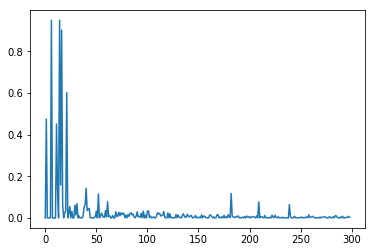

In [133]:
env = GridWorld1

def _next_action(Q, state, actions, eps=0.1):
    """ Compute the policy and return the action provided by the policy the given state.
    The action is thus defined as $argmax_a Q(x_t, a)$ with an $\epsilon$-greedy exploration policy."""
    
    action = actions[np.argmax(Q[state, actions])]
    
    # exploration algorithm
    if np.random.random() < eps and  actions != [action]:
        action = np.random.choice(list(set(actions) - set([action])))

    return action


def _learning_rate(N, state, action):
    return 1/N[state, action]

def _q_episode(Q, N, env, eps=0.1, gamma=0.95, t_max=1000):
    state = env.reset()
    Q = Q.copy()
    t = 0
    term = False
    old_state = state
    n_actions = len(env.action_names)
#     N = np.zeros((env.n_states, n_actions))
    while t < t_max and not term:
        action = _next_action(Q, state, env.state_actions[state], eps=eps)
        N[state, action] += 1 
        alpha = _learning_rate(N, state, action)
        nexts, reward, term = env.step(state, action)
        Q[state, action] = (1-alpha)*Q[state, action] + alpha* \
                            (reward + gamma*np.max(Q[nexts]))
        t += 1
        state = nexts
    return Q, N


    
def q_learning(env, gamma=0.95, eps=0.3, max_iter=300, max_err=0):
    """ 
    Applies to Q Learning algorithm in ordeer to get the best policy.
    The function returns all Q computed at each step. 
    """ 

    n = 0
    n_actions = len(env.action_names)
    Q = np.zeros((env.n_states, n_actions))
    N = np.zeros((env.n_states, n_actions))
    Qs = []
    err = max_err + 1
    while n < max_iter: # and err > max_err: #TODO add convergence criteria
        new_q, N = _q_episode(Q, N, env, eps=eps, t_max=1000, gamma=gamma)
        n += 1
        Qs.append(new_q)
        err = np.max(Q - new_q)
        Q = new_q
    return Qs


qs = q_learning(env, max_iter=150)
q = qs[-1]

diff_q = []
for i in range(1, len(qs)):
    diff_q.append( np.max( np.abs(qs[i] - qs[i-1])) )
plt.plot(cv_q)
plt.show()

The latter plot shows the convergence of Q. But we should check it has converged to a correct value by rendering the grid.

In [115]:
import gridrender
def q_export(q, actions):
    ret = []
    for i in range(q.shape[0]):
        ret.append(q[i, actions[i]])
    return ret

q_exp = q_export(q, env.state_actions)
gridrender.render_q(env, q_exp)

Great! Now, we can deduce from each $Q_n$ its corresponding policy $\pi_n$ and from  $\pi_n$, we obtain $V_n$ applying the policy evaluation from Question 4.

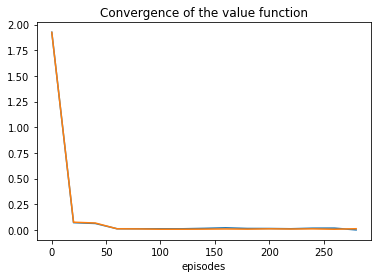

In [130]:
def _q_to_policy(Q, actions):
    """ Return the optimal policy from Q"""
    n_states = Q.shape[0]
    policy = np.zeros(n_states)
    for i in range(n_states):
        policy[i] = actions[i][np.argmax(Q[i, actions[i]])]
    return policy


def q_to_value(Q, env, N=1000):
    """ Return the estimated value function from Q """

    def policy(actions, state, pi=None):
        return pi[state]
    
    pi = _q_to_policy(Q, env.state_actions)
    v = mc_value(env, policy, N=N, pi=pi)
    return v[-1]
    
n_q = len(qs)
values = []
step = 10
x = range(0, n_q, step)

for i in x:
    v = q_to_value(qs[i], env, N=1000)
    values.append(v)

cv_v = []
cv_gt = []
Vstar=[0.877,0.928,0.988,0,0.824,0.928,0,0.778,0.824,0.877,0.828]
for i in range(len(values)):
    cv_v.append( np.max( np.abs(values[i] - values[-1])) )
    cv_gt.append( np.max( np.abs(values[i] - Vstar)) )
plt.plot(x, cv_v, label="$||v^{π_{\intfy}} − v^{π_n} ||_∞$")
plt.plot(x, cv_gt, label="$||v_∗ − v^{π_n} ||_∞$")
plt.xlabel("episodes")
plt.legend()
plt.title("Convergence of the value function")
plt.show()

In [131]:
values[-1]

array([0.87928898, 0.93160122, 0.98119874, 0.        , 0.819534  ,
       0.92972258, 0.        , 0.76632499, 0.81865142, 0.88021688,
       0.8313971 ])